In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import glob
import pickle
import patsy
import json

from scipy.stats import linregress
from scipy.stats import chi2_contingency as chi
from scipy.stats import t as ttest

import statsmodels.api as sm
from statsmodels.stats import multitest
from statsmodels.stats.proportion import proportion_confint as ci
from statsmodels.stats.weightstats import DescrStatsW

import seaborn as sns

%matplotlib inline
sns.set(style="white")
plt.rc('font',family='Times New Roman')

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Prepare dataset

In [2]:
# Load data as pandas dataframe

########## Read name ###########

list_of_files = glob.glob('./Patients_*.pkl')
list_of_files_1 = glob.glob('./Monitoring_new_features_*.pkl')
latest_file = max(list_of_files, key=os.path.getctime)
latest_file_1 = max(list_of_files_1, key=os.path.getctime)
##########

print("Loading... ",latest_file)
print("Loading... ",latest_file_1)
with open(latest_file, "rb") as f:
    X_prime = pickle.loads(f.read())
with open(latest_file_1, "rb") as f:
    X = pickle.loads(f.read())
print("Done")

Loading...  ./Patients_0922_0640.pkl
Loading...  ./Monitoring_new_features_0919_0108.pkl
Done


In [3]:
for col in ['age', 'mean_FiO2_bi', 'mean_tracheal_sanations_per_day_bi', 'min_RASS_bi',
            'mean_PBSS_bi', 'min_conscious_level_bi', 'max_temperature_bi', 'mean_antibiotics_per_day_bi',
            'days_in_hospital', 'CHARLSON_FIRST']:
    print("Column:\t\t{}\nNaN Values:\t{}\n--".format(col, X_prime.loc[:,col].isnull().values.any()))
    X_prime.loc[:,col] = X_prime.loc[:,col].fillna(X_prime.loc[:,col].mean())

Column:		age
NaN Values:	True
--
Column:		mean_FiO2_bi
NaN Values:	True
--
Column:		mean_tracheal_sanations_per_day_bi
NaN Values:	True
--
Column:		min_RASS_bi
NaN Values:	True
--
Column:		mean_PBSS_bi
NaN Values:	True
--
Column:		min_conscious_level_bi
NaN Values:	True
--
Column:		max_temperature_bi
NaN Values:	True
--
Column:		mean_antibiotics_per_day_bi
NaN Values:	True
--
Column:		days_in_hospital
NaN Values:	True
--
Column:		CHARLSON_FIRST
NaN Values:	True
--


In [4]:
# Add column that patient has at least one HAI 

X_prime.fillna(0)

infections =  ('infection_CNS',
               'infection_respiratory',
               'infection_bloodstream',
               'infection_urinary')


for id_ in X_prime.index:
    for inf in infections:
        if (X_prime.loc[id_, inf] ==1):
            if (X_prime.loc[id_, inf + '_1st_day'] >=2):
                X_prime.loc[id_, 'HAI'] =1

                
X_prime.HAI = X_prime.HAI.fillna(0)
print('Patients with at least one HAI:\t\t', X_prime.HAI.sum())
print('Incidence rate of HAI, %:\t\t', X_prime.HAI.sum() / len(X_prime) *100)
print('Incidence rate of HAI, CI:\t\t', ci(X_prime.HAI.sum(), len(X_prime), alpha=0.05, method='normal'))

Patients with at least one HAI:		 1126.0
Incidence rate of HAI, %:		 49.256342957130364
Incidence rate of HAI, CI:		 (0.47206918371742246, 0.51305767542518477)


In [5]:
X_prime1 = pd.get_dummies(X_prime, columns=['outcome'], dummy_na=True, drop_first=False)
X_prime1 = pd.get_dummies(X_prime1, columns=['disease_type'], dummy_na=True, drop_first=False)
X_prime1 = pd.get_dummies(X_prime1, columns=['gender'], dummy_na=True, drop_first=False)


# Make new dataset with dates from 2011-01-01 to 2016-12-31
X_new_R = X_prime1.loc[(X_prime1.date >= "2011-01-01") & (X_prime1.date <= "2016-12-31"), :]
X_new = X_prime.loc[(X_prime.date >= "2011-01-01") & (X_prime.date <= "2016-12-31"), :]
X_new_R.to_csv('./dataset_R.csv')

# Define functions

In [6]:
# Function for descriptive statistics in binary variables

dates = [('201{}-01-01'.format(x - 1), '201{}-01-01'.format(x)) for x in range(2,8)]

ots = ['craniotomy', 'device', 'endovascular', 'endonasal', 'spinal']

def descr_by_years(X):
    result = pd.DataFrame()
    already_seen_ids = []
    for date_left, date_right in dates:

        # Skip already seen IDs
        X = X.loc[~X.ID.isin(already_seen_ids)]
        already_seen_ids = already_seen_ids + X.loc[(X.date >= date_left) & \
                                                    (X.date < date_right)].ID.unique().tolist()

        P = X.loc[(X.date >= date_left) \
            & (X.date < date_right), 'ID'].unique().shape[0]
        
        age = X.loc[(X.date >= date_left) & (X.date < date_right), 'age']
        
        result.loc[date_left[:4], 'Patients, total'] = P
        
        result.loc[date_left[:4], 'children'] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                          (X.age <=18), 'age'].shape[0]
        result.loc[date_left[:4] + ' %', 'children'] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                          (X.age <=18), 'age'].shape[0] / P)*100
        
        result.loc[date_left[:4], 'male gender'] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X.gender == 'M')].shape[0]
        result.loc[date_left[:4] + ' %', 'male gender'] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X.gender == 'M')].shape[0] / P)*100
        
        for ot in ots:
            result.loc[date_left[:4], ot] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X['ot_' + ot + '_count_binary'] == 1)].shape[0]
            result.loc[date_left[:4] + ' %', ot] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X['ot_' + ot + '_count_binary']== 1)].shape[0] / P)*100
        
        
        result.loc[date_left[:4], 'other surgery'] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X.ot_other_count_binary == 1)].shape[0]
        result.loc[date_left[:4] + ' %', 'other surgery'] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                         (X.ot_other_count_binary == 1)].shape[0] /P)*100
        
        for i  in X.disease_type.unique():
            result.loc[date_left[:4], i] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                 (X.disease_type == i)].shape[0]
            result.loc[date_left[:4] + ' %', i] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                 (X.disease_type == i)].shape[0] / P)*100
        
        for i  in X.outcome.unique():
            result.loc[date_left[:4], i] = X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                 (X.outcome == i)].shape[0]
            result.loc[date_left[:4] + ' %', i] = (X.loc[(X.date >= date_left) & (X.date < date_right) &\
                                                 (X.outcome == i)].shape[0] / P)*100

    return result

In [7]:
# Function for descriptive statistics in continuous variables

def continuous_by_years(X):
    continuous = pd.DataFrame()
    already_seen_ids = []
    for date_left, date_right in dates:

        # Skip already seen IDs
        X = X.loc[~X.ID.isin(already_seen_ids)]
        already_seen_ids = already_seen_ids + X.loc[(X.date >= date_left) & \
                                                    (X.date < date_right)].ID.unique().tolist()
        age = X.loc[(X.date >= date_left) & (X.date < date_right), 'age']
        
        continuous.loc[date_left[:4], 'mediane age'] = age.describe()[5]
        
        la = []
        for i in [4,6]:
            l = age.describe()[i]
            la.append(l)
        continuous.loc[date_left[:4], 'IQR age'] = json.dumps(la)
        
        continuous.loc[date_left[:4], 'median CCI'] = X.loc[(X.date >= date_left) & (X.date < date_right),
                                                         'CHARLSON_FIRST'].describe()[5]
        la = []
        for i in [4,6]:
            l = X.loc[(X.date >= date_left) & (X.date < date_right),
                                                         'CHARLSON_FIRST'].describe()[i]
            la.append(l)
        continuous.loc[date_left[:4], 'IQR CCI'] = json.dumps(la)

        continuous.loc[date_left[:4], 'median LOS'] = X.loc[(X.date >= date_left) & (X.date < date_right),
                                                         'days_in_ICU_total'].describe()[5]
        la = []
        for i in [4,6]:
            l = X.loc[(X.date >= date_left) & (X.date < date_right),
                                                         'days_in_ICU_total'].describe()[i]
            la.append(l)
        continuous.loc[date_left[:4], 'IQR LOS'] = json.dumps(la)
        
    return continuous

In [8]:
# Function for cumulative incidence by years (all HAIs)

dates = [('201{}-01-01'.format(x - 1), '201{}-01-01'.format(x)) for x in range(2,8)]

def incidence_by_years(X, infection):
    result = pd.DataFrame()
    already_seen_ids = []
    for date_left, date_right in dates:

        # Skip already seen IDs
        X = X.loc[~X.ID.isin(already_seen_ids)]
        already_seen_ids = already_seen_ids + X.loc[(X.date >= date_left) & \
                                                    (X.date < date_right)].ID.unique().tolist()

        INF = X.loc[(X.date >= date_left) \
            & (X.date < date_right) \
            & (X[infection] == 1), :].shape[0]

        P_DAYS = X.loc[(X.date >= date_left) & (X.date < date_right), 'days_in_ICU_total'].sum()

        P = X.loc[(X.date >= date_left) \
            & (X.date < date_right), 'ID'].shape[0]
        
        CI = ci(INF, P, alpha=0.05, method='normal')

        result.loc[date_left[:4], 'Patients, total'] = P
        result.loc[date_left[:4], 'Patients with ' + infection] = INF
        result.loc[date_left[:4], 'Incidence, %, ' + infection] = np.around(((INF / P) * 100), decimals=2)
        result.loc[date_left[:4], 'Incidence, CI ' + infection] = str(CI)
        result.loc[date_left[:4], 'Patient-days, total'] = P_DAYS
        result.loc[date_left[:4], 'Incidence per 1000 patient-days ' + infection] = np.around(((INF / P_DAYS) * 1000),
                                                                                              decimals=2)
    return result

# Chi-square test
# chi(np.array([[277, 51], [325, 24]]))[1]

In [9]:
# Function for incidence rate by years (device-associated HAIs)

dates = [('201{}-01-01'.format(x - 1), '201{}-01-01'.format(x)) for x in range(2,8)]


def devices_by_years(X, long, factor, infection):
    result = pd.DataFrame()
    already_seen_ids = []
    for date_left, date_right in dates:
        # Skip already seen IDs
        X = X.loc[~X.ID.isin(already_seen_ids)]
        already_seen_ids = already_seen_ids + X.loc[(X.date >= date_left)\
                                                    & (X.date < date_right)].ID.unique().tolist()
        
        PTS_WITH_DEVICE = X.loc[(X.date >= date_left) & (X.date < date_right) \
                                & (X[factor] ==1) , 'ID'].shape[0]
        
        DEVICE_DAYS = long.loc[(long.date >= date_left) \
                            & (long.date < date_right)].groupby('ID_1').sum()[factor].sum()
        
        DEVICE_ASSOC_INF = X.loc[(X.date >= date_left) \
                                 & (X.date < date_right) & (X[infection] ==1) \
                                 & (X[infection + '_1st_day'] - X[factor + '_1st_day'] >=2), "ID"]
        
        PTS_WITH_INF = X.loc[(X.date >= date_left) \
                             & (X.date < date_right) & (X[infection] ==1), "ID"]
        
        INF_DAYS = long.loc[(long.ID.isin(PTS_WITH_INF)), infection].sum()
        
        DEVICE_ASSOC_INF_DAYS = long.loc[(long.ID.isin(DEVICE_ASSOC_INF)), infection].sum()
        
        CI = ci(DEVICE_ASSOC_INF.shape[0], PTS_WITH_DEVICE, alpha=0.05, method='normal')

        result.loc[date_left[:4], 'Pts with ' + infection] = PTS_WITH_INF.shape[0]
        result.loc[date_left[:4], 'Pts with device, ' + factor] = PTS_WITH_DEVICE
        result.loc[date_left[:4], 'Pts with device-associated infection, ' + factor] = DEVICE_ASSOC_INF.shape[0]
        result.loc[date_left[:4], 'Days with device-associated ' + infection] = DEVICE_ASSOC_INF_DAYS
        result.loc[date_left[:4], 'Days with ' + infection] = INF_DAYS
        
        result.loc[date_left[:4], 'Pts DA/HAI ' + infection] = DEVICE_ASSOC_INF.shape[0] / PTS_WITH_INF.shape[0] *100
        result.loc[date_left[:4], 'Days DA/HAI ' + infection] = DEVICE_ASSOC_INF_DAYS / INF_DAYS *100
        
        result.loc[date_left[:4], 'Incidence of device-associated infection, % ' + factor] = np.around(((DEVICE_ASSOC_INF.shape[0]/
                                                                                                         PTS_WITH_DEVICE) * 100), decimals=2)
        result.loc[date_left[:4], 'Incidence of device-associated infection, CI ' + factor] = str(CI)
        result.loc[date_left[:4], 'Device-days, ' + factor] = DEVICE_DAYS
        result.loc[date_left[:4], 'Incidence per 1000 device-days ' + factor] = np.around(((DEVICE_ASSOC_INF.shape[0] /
                                                                                            DEVICE_DAYS) * 1000), decimals=2)
    return result


# Group description

In [10]:
# Binary variables

d = descr_by_years(X_new)
d = d.T

cols = [col for col in d.columns 
       if ' %' not in col]

for i in d.index.dropna():
    d.loc[i, 'Total'] = d.loc[i, cols].sum()
    
    testp = d.loc['Patients, total', cols]
    testc = d.loc[i, cols]
    test_df = pd.concat([testp, testc], axis=1)
    d.loc[i, 'pvalue'] = chi(test_df)[1]
    
d['p-adjusted'] = multitest.multipletests(d.pvalue, alpha=0.05, method='holm')[1]


/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/multitest.py:176: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphaf / np.arange(ntests, 0, -1)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [11]:
# Continuous variables

cont = continuous_by_years(X_prime)

years = np.array([2011, 2012, 2013, 2014, 2015, 2016])

lm_pvals = []

cols_pv = [col for col in cont.columns if 'median' in col]
for i in cont.columns:
    if i in cols_pv:
        a = linregress(cont[i].values.astype(float), years)[3]
        lm_pvals.append(a)
    else:
        a = 0
        lm_pvals.append(a)
    
cont = cont.T
cont['Total'] = cont.mean(axis=1)
cont['pvalue'] = lm_pvals

descriptive_stat = pd.concat([d, cont], axis=0)

descriptive_stat.to_csv('./Plots_monitoring/descriptive_stat.csv')

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [12]:
X_prime.days_in_ICU_total.describe()

count    2286.000000
mean       20.062117
std        36.295090
min         1.000000
25%         6.000000
50%        10.000000
75%        22.000000
max       898.000000
Name: days_in_ICU_total, dtype: float64

# Incidence of all HAIs

In [13]:
infections_device = {'factor' : ['mechanical_ventilation',
                                 'urinary_catheter',
                                 'EVD',
                                 'central_line'],
                     'infection' : ['infection_respiratory',
                                    'infection_urinary',
                                    'infection_CNS',
                                    'infection_bloodstream']}

infections_device = pd.DataFrame.from_dict(infections_device)

In [14]:

incidence_years = pd.DataFrame()
pvalues = []

infections =  ('infection_respiratory',
               'infection_urinary',
               'infection_CNS',
               'infection_bloodstream',
               )

for infection in infections:
    res = incidence_by_years(X_new, infection)
    
    testp = res.loc[:, 'Patients, total']
    testc = res.loc[:, 'Patients with ' + infection]
    test_df = pd.concat([testp, testc], axis=1)
    p = chi(test_df)[1]
    pvalues.append(p)
    incidence_years = pd.concat([incidence_years, res.T])

incidence_years = incidence_years.T


In [15]:
# Set dataframe with incidence in % to plot

cols = [col for col in incidence_years.columns if ' %' in col]
inc_percent = incidence_years.loc[:, cols]

part_1 = inc_percent.T

part_1['p-value'] = pvalues


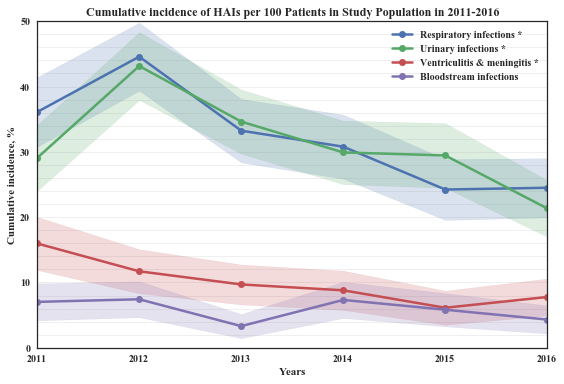

In [16]:
# Plot incidence in %, by years

palette = sns.color_palette()
ax = inc_percent.plot(style='-o', linewidth=2.5)

# Get a reference to the x-points corresponding to the dates and the the colors
x = np.arange(len(inc_percent.index.unique()))

# Calculate and add 95%CI
cols_ci = [col for col in incidence_years.columns if 'CI' in col]
for j in cols_ci:
    i0 = incidence_years.loc[:, j]
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))
    
plt.legend(labels = ['Respiratory infections *',
                     'Urinary infections *',
                     'Ventriculitis & meningitis *',
                     'Bloodstream infections'])
plt.title('Cumulative incidence of HAIs per 100 Patients in Study Population in 2011-2016')
plt.ylabel('Cumulative incidence, %')
plt.xlabel('Years')
plt.ylim(0, 50)
plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.3)

plt.tight_layout()

plt.savefig('./Plots_monitoring/incidence_percent_HAI.pdf', bbox_inches="tight", dpi=600)



part_1 = pd.concat([part_1, incidence_years.loc[:, cols_ci].T], axis=0)


### Plot linear regression for incidence rate per 1000 patient-days

In [17]:
# Set data for plotting (long format)

cols = [col for col in incidence_years.columns if ' 1000' in col]
inc_ptsdays = incidence_years.loc[:, cols]

k = inc_ptsdays.T
k['factor'] = infections_device.loc[:,['infection']].values
k = pd.melt(k, id_vars=['factor'], value_vars=['2011', '2012', '2013', '2014', '2015', '2016'])
k.value = k.value.astype('float')
k.variable = k.variable.astype('float')


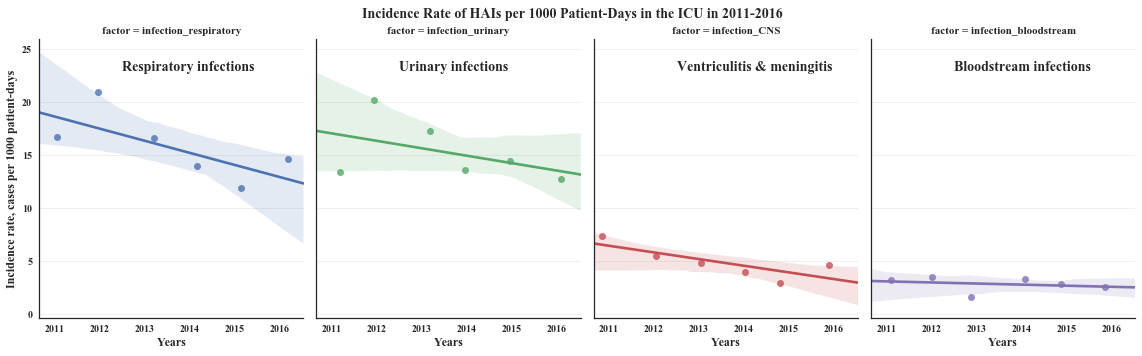

In [18]:
# Plot by seaborn lmplot

g = sns.lmplot(x="variable", y="value", hue="factor", col="factor", data=k, aspect=.8, x_jitter=.2)

g.fig.suptitle('Incidence Rate of HAIs per 1000 Patient-Days in the ICU in 2011-2016', fontsize=14)

g.set_xlabels("Years",size = 12)
g.set_ylabels("Incidence rate, cases per 1000 patient-days",size = 12)
plt.subplots_adjust(top=0.89)

titles = ['Respiratory infections',
         'Urinary infections',
         'Ventriculitis & meningitis',
         'Bloodstream infections']
for ax, title in zip(g.axes.flat, titles):
    ax.grid(b=True, which='major', axis='y',alpha=0.3)
    ax.text(2012.5, 23, title, fontsize=14)

    
plt.savefig('./Plots_monitoring/incidence_days_HAI.pdf', bbox_inches="tight", dpi=600)

# Incidence of Device-associated infections 

### Calculate variables

In [19]:

dev = pd.DataFrame()
pvalues = []


for f, i in infections_device.loc[:,['factor', 'infection']].values:
    res = devices_by_years(X_new, X, f, i)
    
    testp = res.loc[:, 'Pts with device, ' + f]
    testc = res.loc[:, 'Pts with device-associated infection, ' + f]
    test_df = pd.concat([testp, testc], axis=1)
    p = chi(test_df)[1]
    pvalues.append(p)
    dev = pd.concat([dev, res.T])

dev = dev.T


### Plot cumulative incidence

In [20]:
# Set dataframe for plotting
cols = [col for col in dev.columns if '%' in col]
inc_percent_dev = dev.loc[:, cols]

part_2 = inc_percent_dev.T

part_2['p-value'] = pvalues


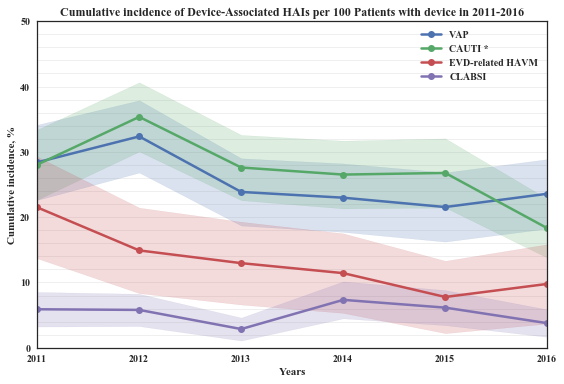

In [21]:

# Plot incidence of device-associated infections in %
ticks = ('VAP','CAUTI *', 'EVD-related HAVM', 'CLABSI')

palette = sns.color_palette()
ax = inc_percent_dev.plot(style='-o', linewidth=2.5)
ax.set_ylim(0, 50)

# Get a reference to the x-points corresponding to the dates and the the colors
x = np.arange(len(inc_percent_dev.index.unique()))

# Calculate and add 95%CI
cols_ci = [col for col in dev.columns if 'CI' in col]
for j in cols_ci:
    i0 = dev.loc[:, j]
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))

plt.legend(labels = ticks)
plt.ylim(0, 50)
plt.xlabel('Years')
plt.title('Cumulative incidence of Device-Associated HAIs per 100 Patients with device in 2011-2016')
plt.ylabel('Cumulative incidence, %')
plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.3)
plt.tight_layout()

plt.savefig('./Plots_monitoring/incidence_percent_DA-HAI.pdf', bbox_inches="tight", dpi=600)


part_2 = pd.concat([part_2, dev.loc[:, cols_ci].T], axis=0)

incidence_final = pd.concat([part_1, part_2], axis=0)
incidence_final.to_csv('./Plots_monitoring/incidence_final.csv')

### Plot linear regression for incidence rate per 1000 device-days

In [22]:
# Set data for plotting (long format)

cols = [col for col in dev.columns if '1000' in col]
inc_devdays = dev.loc[:, cols]

k = inc_devdays.T
k['factor'] = infections_device.loc[:,['factor']].values
k = pd.melt(k, id_vars=['factor'], value_vars=['2011', '2012', '2013', '2014', '2015', '2016'])
k.value = k.value.astype('float')
k.variable = k.variable.astype('float')



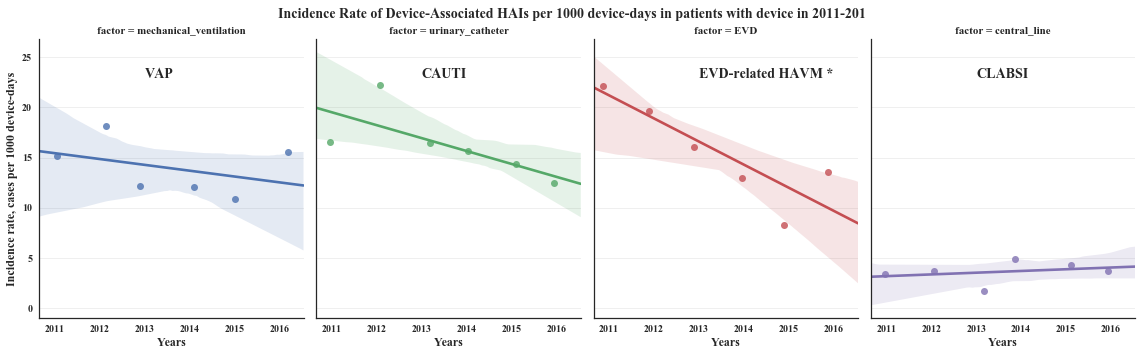

In [23]:
# Plot by seaborn lmplot

g = sns.lmplot(x="variable", y="value", hue="factor", col="factor", data=k, aspect=.8, x_jitter=.2)

g.fig.suptitle('Incidence Rate of Device-Associated HAIs per 1000 device-days in patients with device in 2011-201', fontsize=14)

g.set_xlabels("Years",size = 12)
g.set_ylabels("Incidence rate, cases per 1000 device-days",size = 12)
plt.subplots_adjust(top=0.89)

titles = ['VAP','CAUTI', 'EVD-related HAVM *', 'CLABSI']
for ax, title in zip(g.axes.flat, titles):
    ax.grid(b=True, which='major', axis='y',alpha=0.3)
    ax.text(2013, 23, title, fontsize=14)
    
plt.savefig('./Plots_monitoring/incidence_days_DA-HAI.pdf', bbox_inches="tight", dpi=600)

# Device utilization ratio

In [24]:
# Extract data from dataframes

s = incidence_years['Patients, total']
s = s.iloc[:, 0]
s = pd.DataFrame(s).T
s.index = ['Patients,\ntotal']

e = incidence_years['Patient-days, total']
e = e.iloc[:, 0]


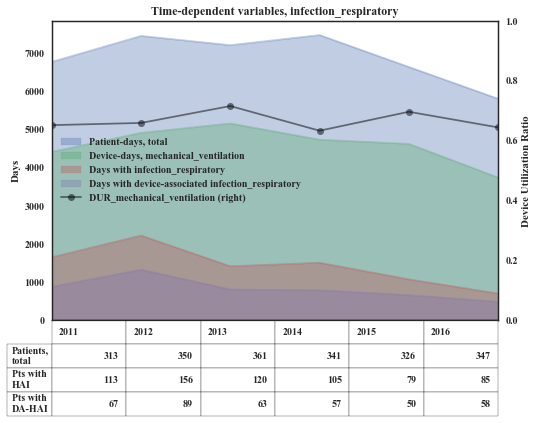

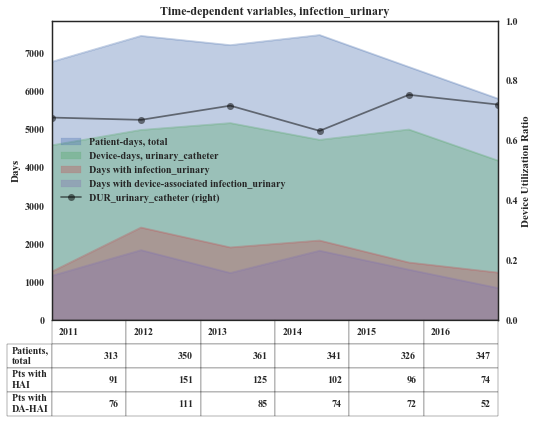

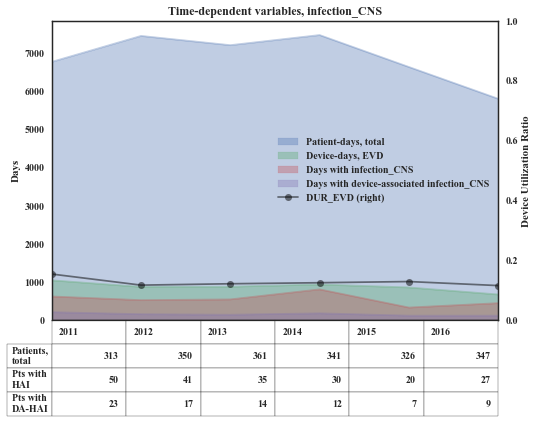

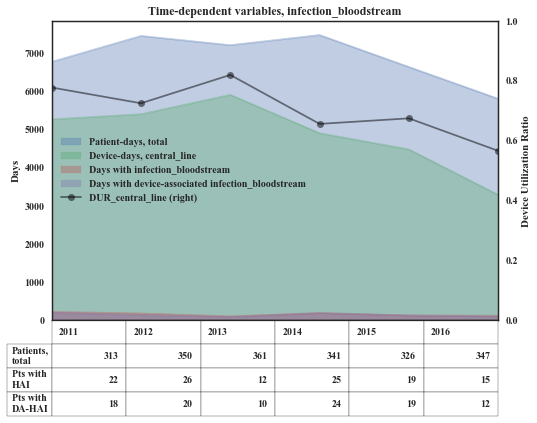

In [25]:

DUR = pd.DataFrame()

for factor, infection in infections_device.loc[:,['factor', 'infection']].values:
    
    fig, ax = plt.subplots()
    
    q = dev['Device-days, ' + factor]
    u = dev['Days with ' + infection]
    w = dev['Days with device-associated ' + infection]

    dur = q / e

    DUR['DUR_' + factor] = dur.values
    r = pd.concat([e, q, u, w], axis=1)
    r.plot.area(stacked=False, ax=ax, alpha=0.35)
    plt.ylabel('Days')

    pd.DataFrame(DUR['DUR_' + factor]).plot(secondary_y=True, style='-o', color='black', alpha=0.5, label='DUR', ax=ax)
    plt.xticks([])
    ax.right_ax.set_ylabel('Device Utilization Ratio')
    plt.ylim(0, 1)

    # Plot table
    t = dev.loc[:, 'Pts with device-associated infection, ' +factor]
    t = pd.DataFrame(t).T
    t.index = ['Pts with\nDA-HAI']
    o = dev.loc[:, 'Pts with ' + infection]
    o = pd.DataFrame(o).T
    o.index = ['Pts with\nHAI']
    y = pd.concat([s.astype(int), o.astype(int), t.astype(int)], axis=0)
    table = plt.table(cellText=y.values, cellLoc='right',
      rowLabels=y.index, rowLoc='left', colLoc='left', colLabels=y.columns)
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
      
    plt.title('Time-dependent variables, ' + infection)
    
    plt.savefig('./Plots_monitoring/time_' + infection +'.pdf', bbox_inches="tight", dpi=600)

# Linear regression to compare variables by years

In [26]:
# Prepare data

s = pd.DataFrame(s).T
s.columns = ['Patients, total']

DUR.index = s.index

In [27]:
# Table with % of days and pts

pvalsp = []
pvalsd = []
totalp = []
totald = []
cip = []
cid = []

pt = pd.DataFrame()
da = pd.DataFrame()

for f, i in infections_device.loc[:,['factor', 'infection']].values:
    pt['pts_' +i] = dev.loc[:, 'Pts DA/HAI ' + i]
    testp = dev.loc[:, 'Pts with ' + i]
    testc = dev.loc[:, 'Pts with device-associated infection, ' + f]
    t = testc.sum() / testp.sum() * 100
    totalp.append(t)
    test_df = pd.concat([testp, testc], axis=1)
    p = chi(test_df)[1]
    pvalsp.append(p)
    c = ci(testc.sum(), testp.sum(), alpha=0.05, method='normal')
    cip.append(c)

    da['days_' +i] = dev.loc[:, 'Days DA/HAI ' + i]
    testp = dev.loc[:, 'Days with ' + i]
    testc = dev.loc[:, 'Days with device-associated ' + i]
    t = testc.sum() / testp.sum() * 100
    totald.append(t)
    test_df = pd.concat([testp, testc], axis=1)
    p = chi(test_df)[1]
    pvalsd.append(p)
    c = ci(testc.sum(), testp.sum(), alpha=0.05, method='normal')
    cid.append(c)

growth_ratep = []
for i in pt.columns:
    g = (np.exp(np.diff(np.log(pt[i].values.astype(float)))) - 1).mean()*100
    growth_ratep.append(g)

growth_rated = []
for i in da.columns:
    g = (np.exp(np.diff(np.log(da[i].values.astype(float)))) - 1).mean()*100
    growth_rated.append(g)

    
pt = pt.T
da = da.T

pt['growth_rate'] = growth_ratep
pt['pvals'] = pvalsp
pt['total'] = totalp
pt['CI total'] = pd.Series(cip, index=pt.index)

da['growth_rate'] = growth_rated
da['pvals'] = pvalsd
da['total'] = totald
da['CI total'] = pd.Series(cid, index=da.index)

ptda = pd.concat([pt, da], axis=0)
ptda.to_csv('./Plots_monitoring/percent_ptda.csv')

In [28]:
colsp = ['Incidence per 1000 patient-days infection_respiratory',
        'Incidence per 1000 patient-days infection_urinary',
        'Incidence per 1000 patient-days infection_CNS',
        'Incidence per 1000 patient-days infection_bloodstream']
finalp = incidence_years.loc[:, colsp]

colsd = [col for col in dev.columns if '%' not in col]
colsd = [col for col in colsd if 'CI' not in col]

finald = dev.loc[:, colsd]

final_table = pd.concat([finalp, finald, s, e, DUR], axis=1)


In [29]:
# Calculate p-values of linear regression and average growth rate 

lm_pvals = []
growth_rate = []

for i in final_table.columns:
    a = linregress(final_table[i].values.astype(float), years)[3]
    lm_pvals.append(a)
    g = (np.exp(np.diff(np.log(final_table[i].values.astype(float)))) - 1).mean()*100
    growth_rate.append(g)
    
final_table = final_table.T
final_table['AVG_growth_rate'] = growth_rate
final_table['pvals'] = lm_pvals
final_table.to_csv('./Plots_monitoring/final_table.csv')

# Intestinal dysfunction

In [30]:
# All intestinal dysfunctions

id_years = incidence_by_years(X_new, 'intestinal_dysfunction')
    
testp = id_years.loc[:, 'Patients, total']
testc = id_years.loc[:, 'Patients with intestinal_dysfunction']
test_df = pd.concat([testp, testc], axis=1)
p = chi(test_df)[1]

print('Cumulative incidence, all dysfunctions p-value:\t', p)

Cumulative incidence, all dysfunctions p-value:	 1.03904050618e-07


In [31]:
# Feeding tube associated intestinal dysfunctions

id_dev = devices_by_years(X_new, X, 'feeding_tube', 'intestinal_dysfunction')
    
testp = id_dev.loc[:, 'Pts with device, feeding_tube']
testc = id_dev.loc[:, 'Pts with device-associated infection, feeding_tube']
test_df = pd.concat([testp, testc], axis=1)
p = chi(test_df)[1]

print('Cumulative incidence, feeding tube associated dysfunctions p-value:\t', p)
id_all = pd.concat([id_years, id_dev], axis=1)
id_all.to_csv('./Plots_monitoring/id_all.csv')

Cumulative incidence, feeding tube associated dysfunctions p-value:	 0.0489795068603


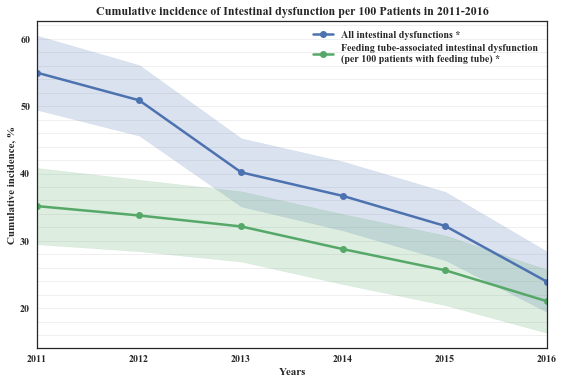

In [32]:
# Plot cumulative incidence
id_inc = id_all.loc[:, ('Incidence, %, intestinal_dysfunction',
                        'Incidence of device-associated infection, % feeding_tube')]

ticks = ('All intestinal dysfunctions *',
         'Feeding tube-associated intestinal dysfunction\n(per 100 patients with feeding tube) *')

palette = sns.color_palette()
ax = id_inc.plot(style='-o', linewidth=2.5)

# Get a reference to the x-points corresponding to the dates and the the colors
x = np.arange(len(id_inc.index.unique()))

# Calculate and add 95% CI
cols_ci = [col for col in id_all.columns if 'CI' in col]
for j in cols_ci:
    i0 = id_all.loc[:, j]
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))

plt.legend(labels = ticks)
plt.xlabel('Years')
plt.title('Cumulative incidence of Intestinal dysfunction per 100 Patients in 2011-2016')
plt.ylabel('Cumulative incidence, %')
plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.3)
plt.tight_layout()

plt.savefig('./Plots_monitoring/incidence_percent_id.pdf', bbox_inches="tight", dpi=600)

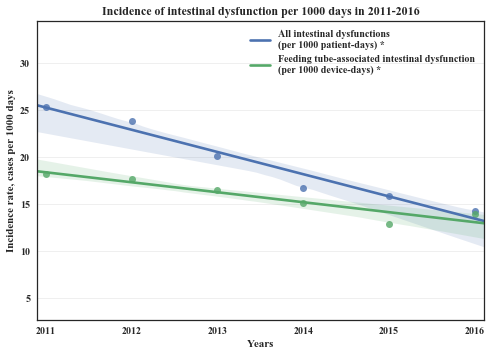

In [33]:
id_days = id_all.loc[:, ('Incidence per 1000 patient-days intestinal_dysfunction',
                         'Incidence per 1000 device-days feeding_tube')]
ticks = ('All intestinal dysfunctions\n(per 1000 patient-days) *',
         'Feeding tube-associated intestinal dysfunction\n(per 1000 device-days) *')

for name in id_days.columns:
    y = id_days[name].values.astype('float')
    sns.regplot(years, y, label=name)
    plt.grid(b=True, which='major', axis='y',alpha=0.3)
plt.legend(labels=ticks)
plt.xlim(2010.9, 2016.1)

plt.xlabel('Years')
plt.title('Incidence of intestinal dysfunction per 1000 days in 2011-2016')
plt.ylabel('Incidence rate, cases per 1000 days')
plt.grid(b=True, which='major', axis='y',alpha=0.3)


plt.savefig('./Plots_monitoring/incidence_days_id.pdf', bbox_inches="tight", dpi=600)

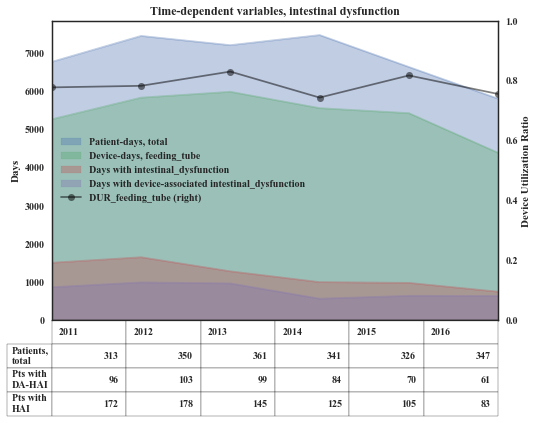

In [34]:
# Device-utilization ratio

DUR = pd.DataFrame()

dur = id_all['Device-days, feeding_tube'] / id_all['Patient-days, total']
DUR['DUR_feeding_tube'] = dur.values

id_plot = id_all.loc[:, ('Patient-days, total', 'Device-days, feeding_tube',
                         'Days with intestinal_dysfunction', 'Days with device-associated intestinal_dysfunction')]
id_table = id_all.loc[:, ('Patients, total', 'Pts with device-associated infection, feeding_tube',
                          'Pts with intestinal_dysfunction')]
id_table.columns = ['Patients,\ntotal', 'Pts with\nDA-HAI', 'Pts with\nHAI']
id_table = id_table.T


fig, ax = plt.subplots()

id_plot.plot.area(stacked=False, ax=ax, alpha=0.35)
plt.ylabel('Days')

DUR.plot(secondary_y=True, style='-o', color='black', alpha=0.5, label='DUR', ax=ax)
plt.xticks([])
ax.right_ax.set_ylabel('Device Utilization Ratio')
plt.ylim(0, 1)

# Plot table

table = plt.table(cellText=id_table.values.astype(int), cellLoc='right',
      rowLabels=id_table.index, rowLoc='left', colLoc='left', colLabels=id_table.columns)
    
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
      
plt.title('Time-dependent variables, intestinal dysfunction')
    
plt.savefig('./Plots_monitoring/time_intestinal_dysfunction.pdf', bbox_inches="tight", dpi=600)

In [35]:
# Linear regression

colsd = [col for col in id_all.columns if '%' not in col]
colsd = [col for col in colsd if 'CI' not in col]

id_stat = id_all.loc[:, colsd]

id_all = id_all.T
lm_pvals = []
growth_rate = []

for i in id_stat.columns:
    a = linregress(id_stat[i].values.astype(float), years)[3]
    lm_pvals.append(a)
    g = (np.exp(np.diff(np.log(id_stat[i].values.astype(float)))) - 1).mean()*100
    growth_rate.append(g)
    
id_stat = id_stat.T
id_stat['AVG_growth_rate'] = growth_rate
id_stat['lm_pvals'] = lm_pvals
id_stat
id_stat.to_csv('./Plots_monitoring/id_stat.csv')

# Pathogens dynamics

## Etiological structure by years

In [36]:
# Upload data

xls = pd.ExcelFile('./pathogens_infections.xlsx')

structure = {}
for sheet_name in xls.sheet_names:
    structure[sheet_name] = xls.parse(sheet_name)

[ 0.  0.  0.  0.  0.  0.]
[ 22.4  19.   14.   19.   16.   21. ]
[ 44.8  40.   38.   34.   32.   38. ]
[ 57.2  51.   45.   48.   53.   52. ]
[ 62.3  56.   48.   49.   56.   53. ]
[ 66.3  59.   52.   50.   60.   56. ]
[ 70.2  65.   57.   59.   66.   61. ]
[ 78.7  71.   64.   71.   74.   65. ]
[ 78.7  71.   64.   75.   75.   70. ]
[ 86.  83.  77.  84.  84.  80.]
[ 89.8  92.   90.   92.   90.   86. ]
[ 0.  0.  0.  0.  0.  0.]
[ 22.   17.   11.4  19.   31.   12. ]
[ 41.6  41.   34.2  38.   58.   50. ]
[ 48.9  51.   34.2  40.   62.   50. ]
[ 53.8  51.   39.9  40.   66.   50. ]
[ 53.8  51.   57.   45.   71.   50. ]
[ 75.7  72.   82.8  78.   84.   82. ]
[ 85.5  72.   82.8  80.   89.   82. ]
[ 87.9  96.   85.6  85.   94.   88. ]
[ 92.7  96.   91.3  90.   99.   88. ]
[  95.1  100.    91.3   92.    99.    88. ]
[ 0.  0.  0.  0.  0.  0.]
[ 32.3  47.   13.   14.   10.   14. ]
[ 42.  71.  20.  21.  15.  14.]
[ 42.  71.  20.  31.  25.  14.]
[ 51.7  80.   27.   31.   25.   21. ]
[ 54.7  80.   40.   31

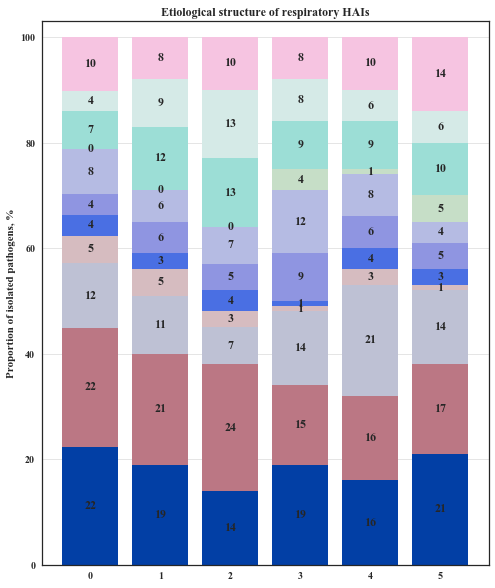

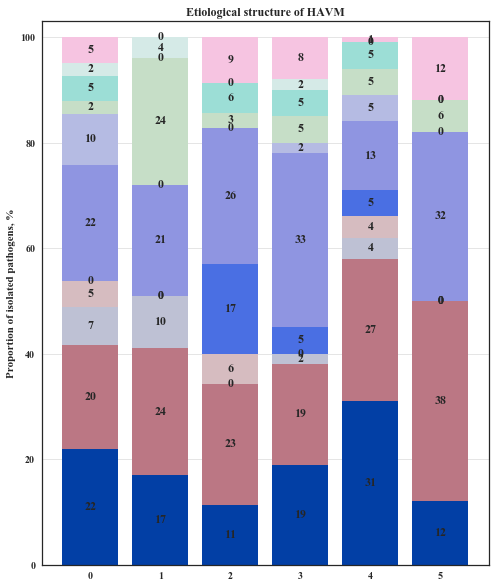

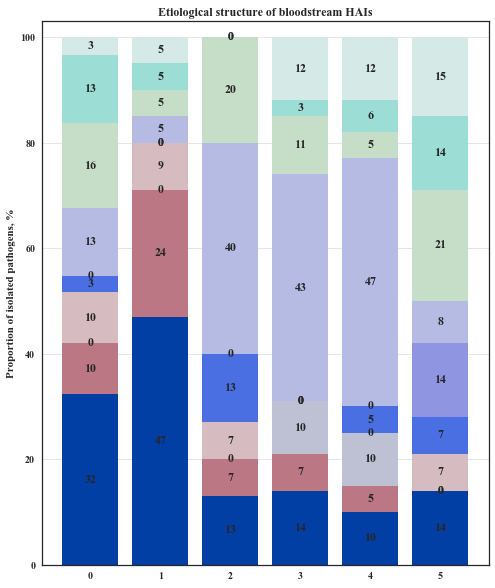

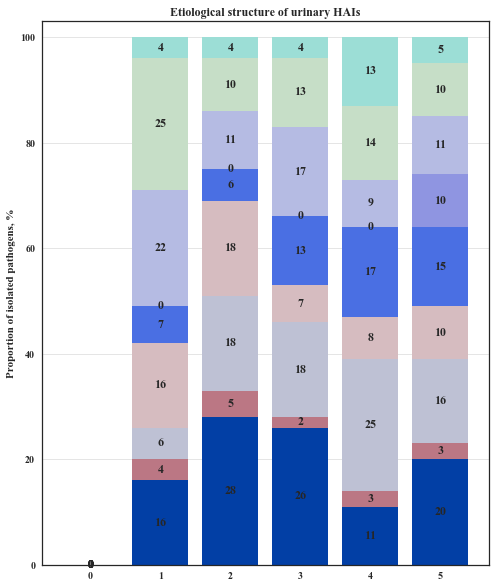

In [37]:
def autolabel(rects):
    # Attach some text labels.
    for rect in rects:
        ax.text(rect.get_x() + rect.get_width() / 2.,
                rect.get_y() + rect.get_height() / 2.,
                '%.0f'%rect.get_height(),
                ha = 'center',
                va = 'center')
        
p = [] # list of bar properties
def create_subplot(matrix, colors, axis):
    bar_renderers = []
    ind = np.arange(matrix.shape[1])
    bottoms = np.cumsum(np.vstack((np.zeros(matrix.shape[1]), matrix)), axis=0)[:-1]
    for i, row in enumerate(matrix):
        print(bottoms[i])
        r = axis.bar(ind, row, width=0.8, color=colors[i], bottom=bottoms[i])
        bar_renderers.append(r)
        autolabel(r)
    #axis.set_title(title,fontsize=28)
    return bar_renderers

colors = ['#023FA5','#BB7784', '#BEC1D4', '#D6BCC0',   '#4A6FE3', '#8F95E1',
           '#B5BBE3', '#C6DEC7', '#9CDED6', '#D5EAE7', '#F6C4E1',   '#E07B91', '#F0B98D', '#F79CD4']

for key in structure.keys():
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(1, 1, 1)
    b = pd.DataFrame(structure[key])
    b=b.fillna(0)
    p.extend(create_subplot(b.as_matrix(), colors, ax))
    plt.ylim(0,103)
    plt.grid(b=True, which='major', axis='y',alpha=0.5)
    plt.xticks(rotation = 0.)
    plt.ylabel('Proportion of isolated pathogens, %')
    plt.title('Etiological structure of ' +key)
    handles, labels = ax.get_legend_handles_labels()
    plt.savefig('./Plots_monitoring/numbers_pathogens_' + key + '.pdf', bbox_inches="tight", dpi=600)


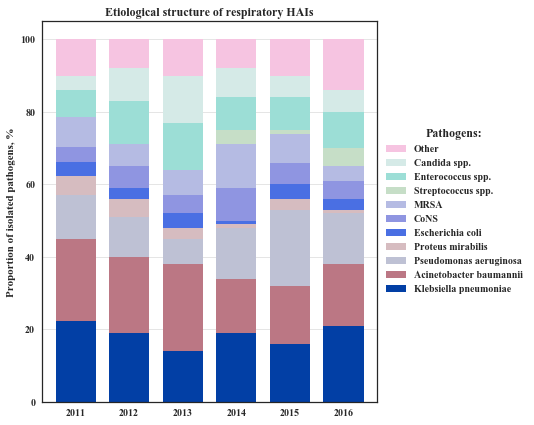

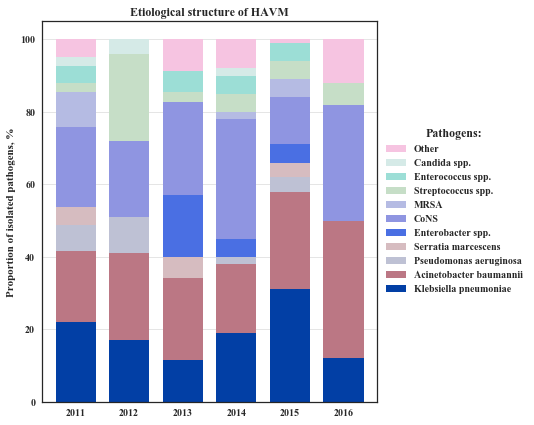

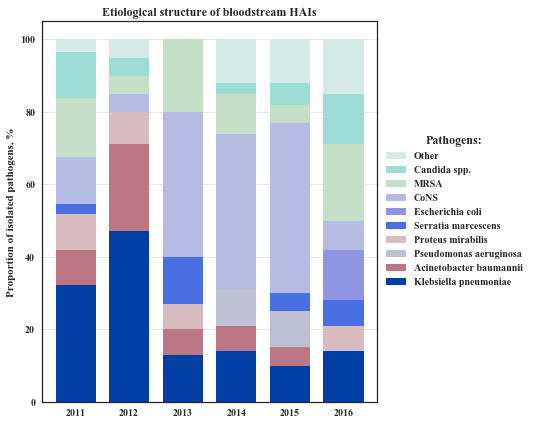

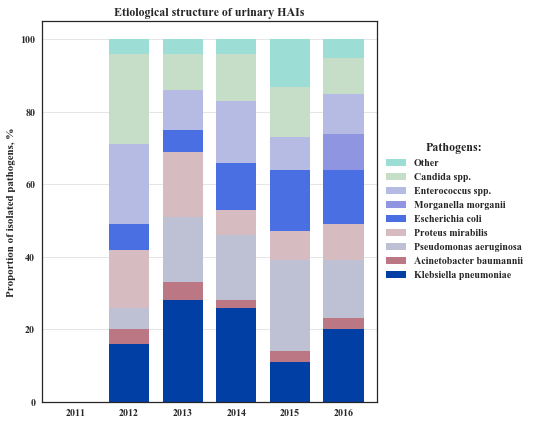

In [38]:
colors = ['#023FA5','#BB7784', '#BEC1D4', '#D6BCC0',   '#4A6FE3', '#8F95E1',
           '#B5BBE3', '#C6DEC7', '#9CDED6', '#D5EAE7', '#F6C4E1',   '#E07B91', '#F0B98D', '#F79CD4']

for key in structure.keys():
    fig = plt.figure(figsize=(6, 7))
    ax = fig.add_subplot(1, 1, 1)
    b = pd.DataFrame(structure[key])
    b.T.plot.bar(stacked=True, color = colors, ax=ax, width=0.75)
    plt.grid(b=True, which='major', axis='y',alpha=0.5)
    plt.xticks(rotation = 0.)
    plt.ylabel('Proportion of isolated pathogens, %')
    plt.title('Etiological structure of ' +key)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Pathogens:', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('./Plots_monitoring/pathogens_' + key + '.pdf', bbox_inches="tight", dpi=600)

__________

# Resistance

In [39]:
# Upload data

xlsk = pd.ExcelFile('kleb_resist.xlsx')
xlsa = pd.ExcelFile('acinet_resistance.xlsx')

kleb = {}
for sheet_name in xlsk.sheet_names:
    kleb[sheet_name] = xlsk.parse(sheet_name)
    
acin = {}
for sheet_name in xlsa.sheet_names:
    acin[sheet_name] = xlsa.parse(sheet_name)
    
CIsK = pd.DataFrame()
CIsA = pd.DataFrame()

for key in sorted(kleb.keys()):
    for i in ('R', 'I', 'S'):
        kleb[key][i + 'n_kleb_' + key] = (np.around((kleb[key]['n_kleb_' + key] * kleb[key][i +'%_kleb_' + key] / 100),
                                                    decimals=0)).astype(int)
        acin[key][i + 'n_acin_' + key] = (np.around((acin[key]['n_acin_' + key] * acin[key][i +'%_acin_' + key] / 100),
                                                    decimals=0)).astype(int)
        CI = []
        for j in range(0, len(kleb[key])):
            a = ci(kleb[key][i +'n_kleb_' + key][j], kleb[key]['n_kleb_' + key][j], alpha=0.05, method='normal')
            CI.append(a)
        
        CIsK[i + '_CI_kleb_' + key] = pd.Series(CI, index=kleb[key]['antibiotic'])
        
        CI = []
        for j in range(0, len(acin[key])):
            a = ci(acin[key][i +'n_acin_' + key][j], acin[key]['n_acin_' + key][j], alpha=0.05, method='normal')
            CI.append(a)
        
        CIsA[i + '_CI_acin_' + key] = pd.Series(CI, index=acin[key]['antibiotic'])
                                                                                    
                                                                                                   

In [40]:
# Prepare datasets for Klebsiella

dataK = pd.DataFrame()
dataA = pd.DataFrame()

for key in sorted(kleb.keys()):
    dataK[key] = pd.Series(kleb[key]['R%_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataA[key] = pd.Series(acin[key]['R%_acin_' + key].values, index=acin[key]['antibiotic'].values)

dataK_Rn = pd.DataFrame()
dataA_Rn = pd.DataFrame()
for key in sorted(kleb.keys()):
    dataK_Rn[key] = pd.Series(kleb[key]['Rn_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataA_Rn[key] = pd.Series(acin[key]['Rn_acin_' + key].values, index=acin[key]['antibiotic'].values)

dataK_n = pd.DataFrame()
dataA_n = pd.DataFrame()
for key in sorted(kleb.keys()):
    dataK_n[key] = pd.Series(kleb[key]['n_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataA_n[key] = pd.Series(acin[key]['n_acin_' + key].values, index=acin[key]['antibiotic'].values)

pvalsK = []
pvalsA = []
for id_ in dataK_n.index.values:
    testp = dataK_n.loc[id_, :]
    testc = dataK_Rn.loc[id_, :]
    test_df = pd.concat([testp, testc], axis=1)
    test_df = test_df.dropna()
    p = chi(test_df)[1]
    pvalsK.append(p)
    
for id_ in dataA_n.index.values:
    testp = dataA_n.loc[id_, :]
    testc = dataA_Rn.loc[id_, :]
    test_df = pd.concat([testp, testc], axis=1)
    test_df = test_df.dropna()
    p = chi(test_df)[1]
    pvalsA.append(p)

In [41]:
# Save full dataset Klebsiella

dataK_full = pd.DataFrame()
for key in sorted(kleb.keys()):
    dataK_full['n_kleb_' + key] = pd.Series(kleb[key]['n_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['Rn_kleb_' + key] = pd.Series(kleb[key]['Rn_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['R%_kleb_' + key] = pd.Series(kleb[key]['R%_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['R_CI_kleb_' + key] = CIsK.loc[:, 'R_CI_kleb_' + key]

    dataK_full['In_kleb_' + key] = pd.Series(kleb[key]['In_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['I%_kleb_' + key] = pd.Series(kleb[key]['I%_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['I_CI_kleb_' + key] = CIsK.loc[:, 'I_CI_kleb_' + key]
    
    dataK_full['Sn_kleb_' + key] = pd.Series(kleb[key]['Sn_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['S%_kleb_' + key] = pd.Series(kleb[key]['S%_kleb_' + key].values, index=kleb[key]['antibiotic'].values)
    dataK_full['S_CI_kleb_' + key] = CIsK.loc[:, 'S_CI_kleb_' + key]

dataK_full['p-value'] = pvalsK
dataK_full.to_csv('./Plots_monitoring/resistance_kleb.csv')

In [42]:
# Save full dataset Acinetobacter

dataA_full = pd.DataFrame()
for key in sorted(acin.keys()):
    dataA_full['n_acin_' + key] = pd.Series(acin[key]['n_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['Rn_acin_' + key] = pd.Series(acin[key]['Rn_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['R%_acin_' + key] = pd.Series(acin[key]['R%_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['R_CI_acin_' + key] = CIsA.loc[:, 'R_CI_acin_' + key]

    dataA_full['In_acin_' + key] = pd.Series(acin[key]['In_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['I%_acin_' + key] = pd.Series(acin[key]['I%_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['I_CI_acin_' + key] = CIsA.loc[:, 'I_CI_acin_' + key]
    
    dataA_full['Sn_acin_' + key] = pd.Series(acin[key]['Sn_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['S%_acin_' + key] = pd.Series(acin[key]['S%_acin_' + key].values, index=acin[key]['antibiotic'].values)
    dataA_full['S_CI_acin_' + key] = CIsA.loc[:, 'S_CI_acin_' + key]

dataA_full['p-value'] = pvalsA
dataA_full.to_csv('./Plots_monitoring/resistance_acin.csv')

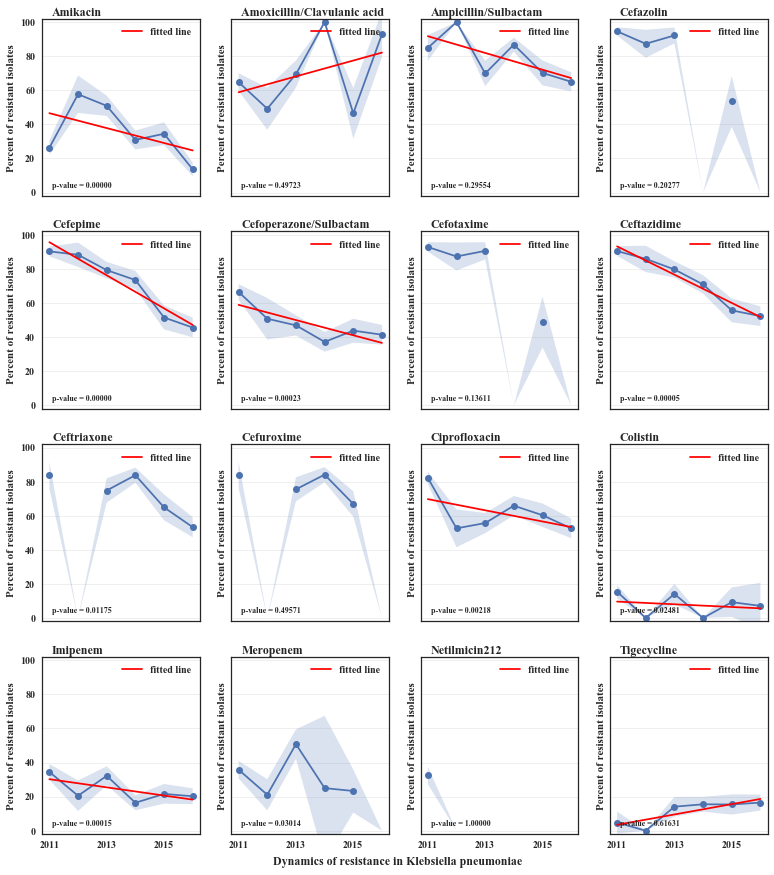

In [43]:
# Plot dynamics for Klebsiella

years = ('2010', '2011', '2013', '2015')
fig, axs = plt.subplots(4,4, figsize=(13, 15), sharex='col', sharey='row')


for ax, d in zip(axs.ravel(), dataK.values):
    ax.plot(d, '-o')
    ax.set_ylim(-2,102)
    ax.set_ylabel('Percent of resistant isolates')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = years
    ax.set_xticklabels(labels)
    ax.grid(b=True, which='major', axis='y',alpha=0.3)
    
    slope, intercept, r_value, p_value, std_err = linregress(range(0,6), d)

    ax.plot(range(0,6), slope*range(0,6) + intercept, 'r', label='fitted line')
    ax.legend(loc='upper right')
    
for ax, text in zip(axs.ravel(), dataK.T.columns.values):
    ax.text(0.1, 104, text)

cols_ci = [col for col in CIsK.columns if 'R' in col]
data_ci = CIsK.loc[:, cols_ci]
data_ci = data_ci.fillna('(0.0, 0.0)')
data_ci = data_ci.T

for ax, i in zip(axs.ravel(), data_ci):
    x = np.arange(len(data_ci.index.unique()))
    i0 = data_ci.loc[:, i].astype(str)
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2)
    
for ax, text in zip(axs.ravel(), pvalsK):
    ax.text(0.1, 3, 'p-value = ' + "%.5f" % text, size=8)

plt.text(-12, -20, 'Dynamics of resistance in Klebsiella pneumoniae')
plt.savefig('./Plots_monitoring/resistance_kleb.pdf', bbox_inches="tight", dpi=600)

In [44]:
dataA = dataA.drop(['Cefuroxime axetil', 'Cefoxitin'])
CIsA = CIsA.drop(['Cefuroxime axetil', 'Cefoxitin'])

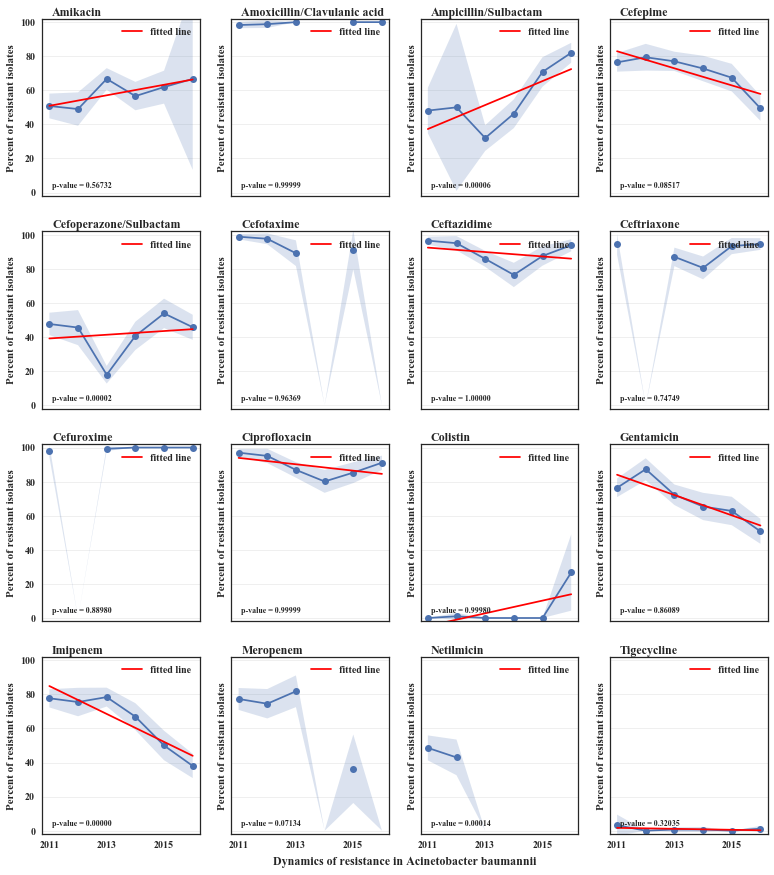

In [45]:
# Plot dynamics for Acinetobacter


years = ('2010', '2011', '2013', '2015')
fig, axs = plt.subplots(4,4, figsize=(13, 15), sharex='col', sharey='row')


for ax, d in zip(axs.ravel(), dataA.values):
    ax.plot(d, '-o')
    ax.set_ylim(-2,102)
    ax.set_ylabel('Percent of resistant isolates')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = years
    ax.set_xticklabels(labels)
    ax.grid(b=True, which='major', axis='y',alpha=0.3)
    
    slope, intercept, r_value, p_value, std_err = linregress(range(0,6), d)

    ax.plot(range(0,6), slope*range(0,6) + intercept, 'r', label='fitted line')
    ax.legend(loc='upper right')
    
for ax, text in zip(axs.ravel(), dataA.T.columns.values):
    ax.text(0.1, 104, text)

cols_ci = [col for col in CIsA.columns if 'R' in col]
data_ci = CIsA.loc[:, cols_ci]
data_ci = data_ci.fillna('(0.0, 0.0)')
data_ci = data_ci.T

for ax, i in zip(axs.ravel(), data_ci):
    x = np.arange(len(data_ci.index.unique()))
    i0 = data_ci.loc[:, i].astype(str)
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2)
    
for ax, text in zip(axs.ravel(), pvalsA):
    ax.text(0.1, 3, 'p-value = ' + "%.5f" % text, size=8)

plt.text(-12, -20, 'Dynamics of resistance in Acinetobacter baumannii')
plt.savefig('./Plots_monitoring/resistance_acinet.pdf', bbox_inches="tight", dpi=600)

## Plot Imipenem only

In [46]:
#Prepare data

# data
ka = pd.DataFrame()
ka['Acinetobacter'] = dataA.loc['Imipenem', :]
ka['Klebsiella'] = dataK.loc['Imipenem', :]

# 95% CIs
cols_ci = [col for col in CIsA.columns if 'R' in col]
data_ci = CIsA.loc[:, cols_ci]
data_ci = data_ci.fillna('(0.0, 0.0)')
data_ci = data_ci.T
a = data_ci['Imipenem']
cols_ci = [col for col in CIsK.columns if 'R' in col]
data_ci = CIsK.loc[:, cols_ci]
data_ci = data_ci.fillna('(0.0, 0.0)')
data_ci = data_ci.T
k = data_ci['Imipenem']

years = ('2011', '2012', '2013','2014', '2015', '2016')
a.index = years
k.index = years
a.name = "Acinetobacter"
k.name = 'Klebsiella'
ka_ci = pd.concat([a, k], axis=1)

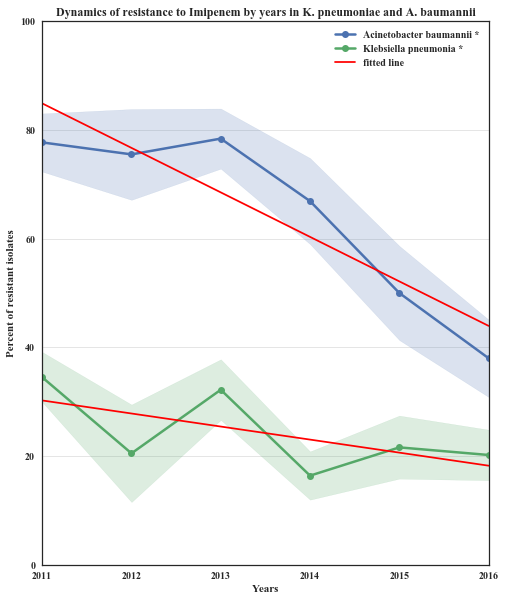

In [47]:
# Plot cumulative incidence

ticks = ('Acinetobacter baumannii *', 'Klebsiella pneumonia *', 'fitted line')

palette = sns.color_palette()
fig, ax = plt.subplots(1,1, figsize=(8, 10))
ka.plot(style='-o', linewidth=2.5, ax=ax)

# Get a reference to the x-points corresponding to the dates and the the colors
x = np.arange(len(ka.index.unique()))

# Calculate and add 95% CI

for j in ka_ci:
    i0 = ka_ci.loc[:, j].astype(str)
    ci0 = [[eval(ci0)[0] * 100, eval(ci0)[1] * 100] for ci0 in i0]
    ci0 = np.array(ci0)
    low = ci0[:,0]
    high = ci0[:,1]
    ax.fill_between(x, low, high, alpha=.2, color=palette.pop(0))
    
for i in ka.columns:
    slope, intercept, r_value, p_value, std_err = linregress(range(0,6), ka[i].values)
    ax.plot(range(0,6), slope*range(0,6) + intercept, 'r', label='fitted line')
    

plt.legend(labels = ticks)
plt.ylim(0,100)
plt.xlabel('Years')
plt.title('Dynamics of resistance to Imipenem by years in K. pneumoniae and A. baumannii')
plt.ylabel('Percent of resistant isolates')
plt.grid(b=True, which='major', axis='y',alpha=0.5)


plt.savefig('./Plots_monitoring/resistance_ka.pdf', bbox_inches="tight", dpi=600)

________________